In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
from statistics import mean
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline 

In [4]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [5]:
confirmed_df.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,665,714,784,840,906,933,996,1026,1092,1176
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,467,475,494,518,539,548,562,584,609,634


In [6]:
confirmed_df.tail(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20
262,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4
263,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [7]:
cols = confirmed_df.keys()

In [8]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [9]:
confirmed.head()
#deaths.head()
#recoveries.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20
0,0,0,0,0,0,0,0,0,0,0,...,665,714,784,840,906,933,996,1026,1092,1176
1,0,0,0,0,0,0,0,0,0,0,...,467,475,494,518,539,548,562,584,609,634
2,0,0,0,0,0,0,0,0,0,0,...,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910
3,0,0,0,0,0,0,0,0,0,0,...,646,659,673,673,696,704,713,717,717,723
4,0,0,0,0,0,0,0,0,0,0,...,19,19,19,19,19,24,24,24,24,25


In [10]:

## confirmed_df

dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 
india_cases = [] 


for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)

    # case studies 
    india_cases.append(confirmed_df[confirmed_df['Country/Region']=='India'][i].sum())
    
  

In [11]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

india_daily_increase = daily_increase(india_cases)

In [12]:
confirmed_df[confirmed_df['Country/Region']=='India']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20
131,NaN,India,21.0,78.0,0,0,0,0,0,0,...,10453,11487,12322,13430,14352,15722,17615,18539,20080,21370


In [13]:
## recoveries_df

dates = confirmed.keys()
world_recoveries = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 
india_recoveries = [] 


for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_recoveries.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)

    # case studies 
    india_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='India'][i].sum())
    
    

In [14]:
#recoveries_df[recoveries_df['Country/Region']=='India']['3/22/20']
l=list(deaths_df[deaths_df['Country/Region']=='India']['4/22/20'])
l[0]

681

In [15]:
def daily_recoveries(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

world_daily_recoveries = daily_recoveries(world_recoveries)
india_daily_recoveries = daily_recoveries(india_recoveries)


In [16]:

## death_df

dates = confirmed.keys()
world_deaths = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 
india_active = []
india_deaths = [] 

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_deaths.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
   
    #active cases country wise
    india_active.append(confirmed_df[confirmed_df['Country/Region']=='India'][i].sum()-recoveries_df[recoveries_df['Country/Region']=='India'][i].sum()-deaths_df[deaths_df['Country/Region']=='India'][i].sum())

    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)
    #india_mortality_rate.append(recoveries_df[recoveries_df['Country/Region']=='India'][i].sum()/confirmed_df[confirmed_df['Country/Region']=='India'][i].sum())
    #india_recovery_rate.append(deaths_df[deaths_df['Country/Region']=='India'][i].sum()/confirmed_df[confirmed_df['Country/Region']=='India'][i].sum())
    
    # case studies 
    india_deaths.append(deaths_df[deaths_df['Country/Region']=='India'][i].sum())
    
    

In [17]:
def daily_deaths(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

world_daily_deaths = daily_deaths(world_deaths)
india_daily_deaths = daily_deaths(india_deaths)


In [18]:
data = {'world_cases': world_cases, 'india_cases': india_cases}

dates = confirmed.keys()

date1 = []
for i in dates:
    date1.append(i)
df_main = pd.DataFrame(data=data,index=date1)

In [19]:
df_comp=df_main.copy()

# % increses daily

In [20]:
df_comp['world_cases_%']=df_comp['world_cases'].pct_change(1).mul(100)
df_comp['india_cases_%']=df_comp['india_cases'].pct_change(1).mul(100)

In [21]:
df_comp['india_cases_%'].tail(2)

4/21/20    8.312207
4/22/20    6.424303
Name: india_cases_%, dtype: float64

# Date Generation for X-Axis

In [22]:
dates = confirmed.keys()
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(dates)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

# India Rates Viz

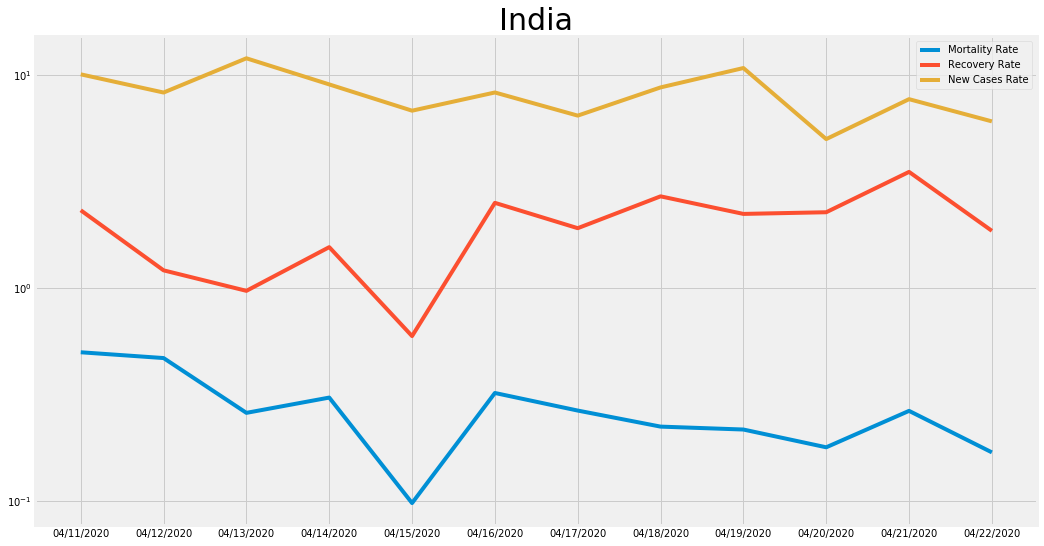

In [23]:
dates = confirmed.keys()
j=0
india_mortality_rate=[]
india_recovery_rate=[]
india_cases_rate=[]
for i in dates: 
    if int(india_daily_recoveries[j])==0 or int(confirmed_df[confirmed_df['Country/Region']=='India'][i].sum())==0:
        india_recovery_rate.append(0)
        
    else:
        india_recovery_rate.append(int(india_daily_recoveries[j])/int(confirmed_df[confirmed_df['Country/Region']=='India'][i].sum()))
    
    if int(india_daily_deaths[j])==0 or int(confirmed_df[confirmed_df['Country/Region']=='India'][i].sum())==0:
        india_mortality_rate.append(0)
    else:
        india_mortality_rate.append(int(india_daily_deaths[j])/int(confirmed_df[confirmed_df['Country/Region']=='India'][i].sum()))
   
    
    if int(india_daily_increase[j])==0 or int(confirmed_df[confirmed_df['Country/Region']=='India'][i].sum())==0 :
        india_cases_rate.append(0)
    else:
        india_cases_rate.append(int(india_daily_increase[j])/int(confirmed_df[confirmed_df['Country/Region']=='India'][i].sum()))
    j=j+1

for i in range(len(india_mortality_rate)):
    india_mortality_rate[i]=float(round(india_mortality_rate[i]*100,4))
    india_recovery_rate[i]=float(round(india_recovery_rate[i]*100,4))
    india_cases_rate[i]=float(round(india_cases_rate[i]*100,4))
    
    
after_days=80
plt.figure(figsize=(16, 9))
plt.plot(future_forcast_dates[after_days:],india_mortality_rate[after_days:])
plt.plot(future_forcast_dates[after_days:],india_recovery_rate[after_days:])
plt.plot(future_forcast_dates[after_days:],india_cases_rate[after_days:])
plt.yscale('log')

plt.title('India', size=30)
#plt.ylim(0,100)
plt.legend(['Mortality Rate', 'Recovery Rate','New Cases Rate'], prop={'size': 10})

In [24]:
#len(future_forcast_dates)
#len(india_daily_increase)
last_days=10
a="No of Cases of "+str(last_days)+" Days"
a

'No of Cases of 10 Days'

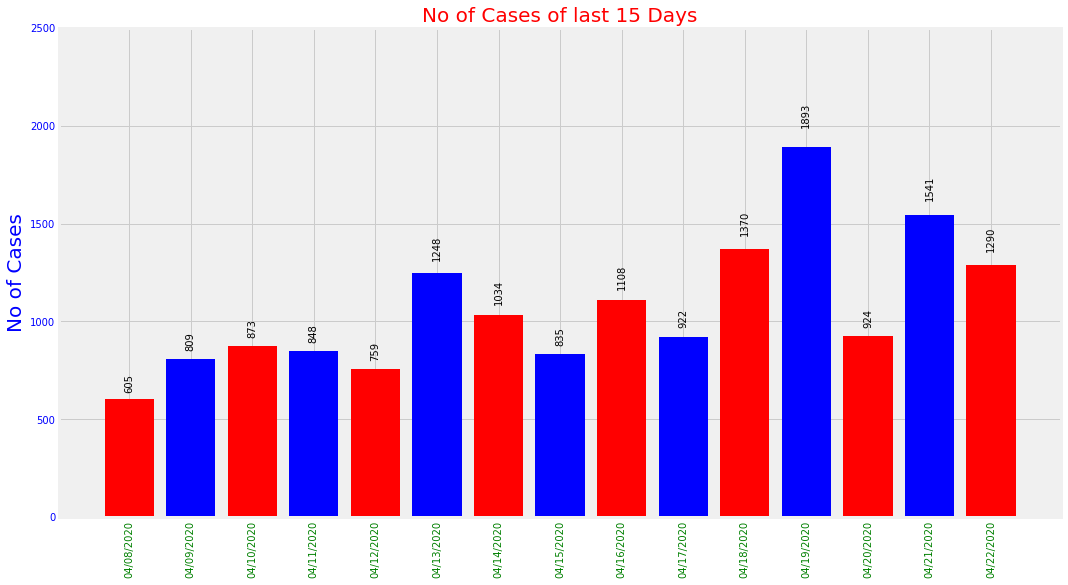

In [25]:
last_days=15
after_days=len(future_forcast_dates)-last_days
fig,ax = plt.subplots(figsize=(16, 9))
rects1 = ax.bar(future_forcast_dates[after_days:], india_daily_increase[after_days:],color=['red','blue'])
plt.title("No of Cases of last "+str(last_days)+" Days", size=20,color="red")
plt.xticks([r for r in range(len(future_forcast_dates[after_days:]))], future_forcast_dates[after_days:], rotation=90)


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,'%d' % int(height), ha='center', va='bottom',rotation=90)
autolabel(rects1)
plt.ylim(0,2500)
plt.ylabel('No of Cases', size=20,color="blue")
plt.xticks(size=10,color="green")
plt.yticks(size=10,color="blue")
plt.show()

In [26]:
last_days=30
after_days=len(future_forcast_dates)-last_days
after_days

62

In [27]:
last_days=10
after_day=len(future_forcast_dates)-last_days
india_cases[len(india_cases)-last_days]


10453

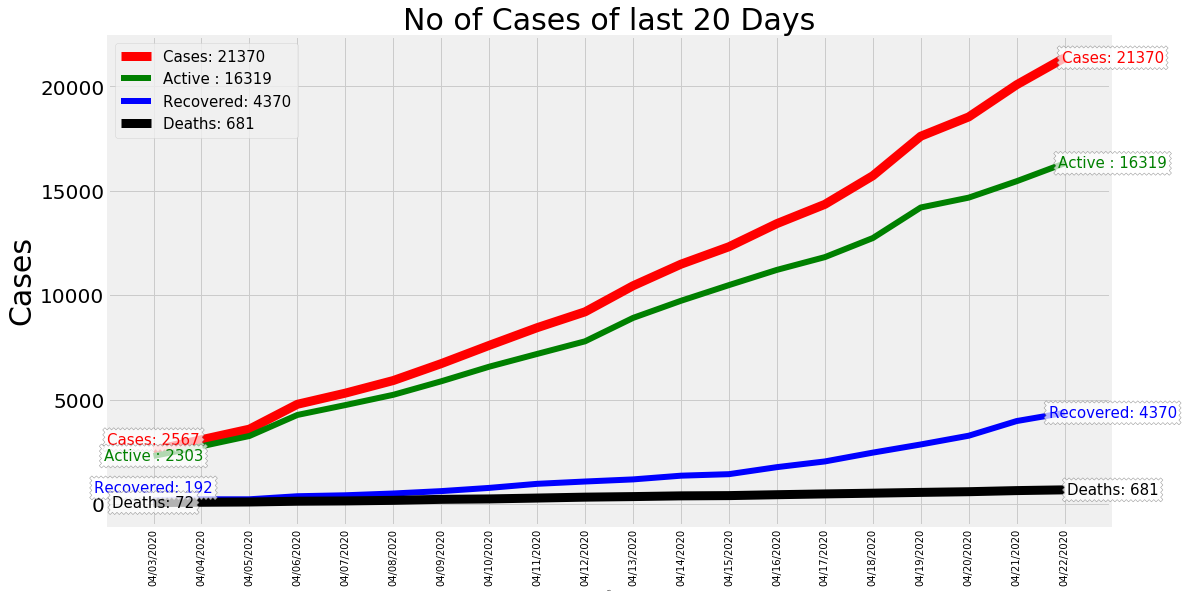

In [30]:
last_days=20
after_day=len(future_forcast_dates)-last_days
fig,ax = plt.subplots(figsize=(16, 9))
ax.plot(india_cases[after_day:len(india_cases)],color='red',lw=9)
ax.plot(india_active[after_day:len(india_active)],color='green',lw=6)
ax.plot(india_recoveries[after_day:len(india_recoveries)],color='blue',lw=6)
ax.plot(india_deaths[after_day:len(india_deaths)],color='black',lw=9)


bbox_props = dict(boxstyle="sawtooth", fc="w", ec="0.4", alpha=0.7)
ax.text(int(len(future_forcast_dates[after_day:len(india_cases)])),  int(india_cases[len(india_cases)-1]), "Cases: "+str(india_cases[len(india_cases)-1]), ha="center", va="center", size=15,bbox=bbox_props,color="red")
ax.text(int(len(future_forcast_dates[after_day:len(india_cases)])),  int(india_active[len(india_active)-1]), "Active : "+str(india_active[len(india_cases)-1]), ha="center", va="center", size=15,bbox=bbox_props,color="green")
ax.text(int(len(future_forcast_dates[after_day:len(india_cases)])),  int(india_recoveries[len(india_recoveries)-1]), "Recovered: "+str(india_recoveries[len(india_cases)-1]), ha="center", va="center", size=15,bbox=bbox_props,color="Blue")
ax.text(int(len(future_forcast_dates[after_day:len(india_cases)])),  int(india_deaths[len(india_deaths)-1]), "Deaths: "+str(india_deaths[len(india_cases)-1]), ha="center", va="center", size=15,bbox=bbox_props,color="Black")

ax.text(0,int(india_cases[len(india_cases)-last_days+1]), "Cases: "+str(india_cases[len(india_cases)-last_days]), ha="center", va="center", size=15,bbox=bbox_props,color="red")
ax.text(0,  int(india_active[len(india_active)-last_days]), "Active : "+str(india_active[len(india_cases)-last_days]), ha="center", va="center", size=15,bbox=bbox_props,color="green")
ax.text(0,  int(india_recoveries[len(india_recoveries)-last_days+7]), "Recovered: "+str(india_recoveries[len(india_cases)-last_days]), ha="center", va="center", size=15,bbox=bbox_props,color="Blue")
ax.text(0,  int(india_deaths[len(india_deaths)-last_days]), "Deaths: "+str(india_deaths[len(india_cases)-last_days]), ha="center", va="center", size=15,bbox=bbox_props,color="Black")




plt.xticks([r  for r in range(len(future_forcast_dates[after_day:len(india_cases)]))], future_forcast_dates[after_day:len(india_cases)], rotation=90,size=10)
plt.yticks(size=20)
plt.yscale('linear')
plt.title("No of Cases of last "+str(last_days)+" Days", size=30)
plt.xlabel('Date', size=2)
plt.ylabel('Cases', size=30)
plt.legend(["Cases: "+str(india_cases[len(india_cases)-1]),"Active : "+str(india_active[len(india_active)-1]),"Recovered: "+str(india_recoveries[len(india_recoveries)-1]),"Deaths: "+str(india_deaths[len(india_deaths)-1])], prop={'size': 15})
plt.show()